In [ ]:
import numpy as np
import random
import gym
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
import time

Constants

In [ ]:
SEED = 436

MAP_SIZE = 6
NUM_OF_TREES = 8

DOWN = 0
UP = 1
RIGHT = 2
LEFT = 3

X = 0
Y = 1

ACTION_SPACE = [DOWN, UP, RIGHT, LEFT]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Environment

In [ ]:
class GridWorldEnv(gym.Env):
    def __init__(self, map_size=6, num_of_trees=8):
        self.map_size = map_size
        self.num_of_trees = num_of_trees

        # We have 4 actions, corresponding to [DOWN, UP, RIGHT, LEFT]
        self.action_space = gym.spaces.Discrete(4)

        self._action_to_direction = {
            DOWN: np.array([1, 0]),
            UP: np.array([-1, 0]),
            RIGHT: np.array([0, 1]),
            LEFT: np.array([0, -1]),
        }

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):
        return {"timestep": self._timestep, "battery": self._battery, "stamina": self._stamina}

    def _get_adjacents(self, pos):
        adj = [(pos[0]+1, pos[1]),
               (pos[0]-1, pos[1]),
               (pos[0], pos[1]+1),
               (pos[0], pos[1]-1)]
        adj = [(x,y) for (x,y) in adj if x != -1 and x != self.map_size and y != -1 and y != self.map_size]
        return adj

    def _locate_trees(self):
        self._trees_location = set()
        excluded_pos = set([tuple(self._agent_location), tuple(self._target_location)])
        side_trees = 0

        while True:
            if len(self._trees_location) == self.num_of_trees or len(excluded_pos) == self.map_size**2:
                break

            selected_pos = random.choice([pos for pos in itertools.product(range(self.map_size), range(self.map_size)) if pos not in excluded_pos])
            num_of_adj = sum(pos in self._trees_location for pos in self._get_adjacents(selected_pos))
            if num_of_adj == 0:
                self._trees_location.add(selected_pos)
            elif num_of_adj == 1:
                adj = [pos for pos in self._get_adjacents(selected_pos) if pos in self._trees_location][0]
                if sum(pos in self._trees_location for pos in self._get_adjacents(adj)) == 0:
                    self._trees_location.add(selected_pos)
            excluded_pos.add(selected_pos)

            if 0 in selected_pos or self.map_size - 1 in selected_pos:
                side_trees += 1
                if side_trees == 2:
                    side_pos = [(x, y) for x in range(self.map_size) for y in range(self.map_size) if x == 0 or x == self.map_size - 1 or y == 0 or y == self.map_size - 1]
                    excluded_pos.update(side_pos)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        random.seed(seed)
        self._timestep = 0
        self._battery = 100
        self._stamina = 100

        start_pos = random.choice([(0,0), (0,1), (0,2), (1,0), (1,1), (2,0)])
        target_pos = random.choice([(3,5), (4,4), (4,5), (5,3), (5,4), (5,5)])
        self._start_location = np.array(start_pos)
        self._agent_location = np.array(start_pos)
        self._target_location = np.array(target_pos)
        self._locate_trees()

    def find_next_states(self, action, current_state):
        direction = self._action_to_direction[action]
        ns1 = np.clip(current_state + direction, 0, self.map_size - 1)
        ns2 = current_state
        ns3 = np.clip(current_state - direction, 0, self.map_size - 1)
        next_states = [ns1, ns2, ns3]

        states_probabilities = [0.8, 0.1, 0.1]

        has_collided = []
        for ns in next_states:
            has_collided.append(any(np.array_equal(ns, loc) for loc in self._trees_location))

        has_arrived = [np.array_equal(ns, self._target_location) for ns in next_states]

        return next_states, states_probabilities, has_collided, has_arrived

    def _move(self, action):
        direction = self._action_to_direction[action]
        wind = np.random.choice(["forward", "stay", "backward"], p = [0.8, 0.1, 0.1])
        if wind == "stay":
            direction = np.array([0,0])
        elif wind == "backward":
            direction = -direction

        dest = np.clip(self._agent_location + direction, 0, self.map_size - 1)
        if any(np.array_equal(dest, loc) for loc in self._trees_location):
            return "collided"
        elif np.array_equal(dest, self._target_location):
            return "arrived"
        else:
            self._agent_location = dest
            return "moved"

    def step(self, action):
        self._timestep += 1
        self._battery -= np.random.normal(0.35, 0.15)
        state = self._move(action)
        reward = np.random.normal(-0.5, 0.25)
        terminated = False
        if state == "arrived":
            reward += np.random.normal(25, 5)
            terminated = True
        elif state == "collided":
            reward += np.random.normal(-1, 0.5)
            self._stamina -= np.random.normal(0.2, 0.1)

        observation = self._get_obs()
        info = self._get_info()

        truncated = False
        if self._battery < 5 or self._stamina < 15:
            truncated = True

        return observation, reward, terminated, truncated, info

    def render(self, arrows=None):
        plt.figure()
        # Show the start
        row = self.map_size - 1 - self._start_location[X]
        col = self._start_location[Y]
        plt.fill([col, col+1, col+1, col], [row, row, row+1, row+1], color='blue')

        # Show the target
        row = self.map_size - 1 - self._target_location[X]
        col = self._target_location[Y]
        plt.fill([col, col+1, col+1, col], [row, row, row+1, row+1], color='red')

        # Show the trees
        for tree in self._trees_location:
            row = self.map_size - 1 - tree[X]
            col = tree[Y]
            plt.fill([col, col+1, col+1, col], [row, row, row+1, row+1], color='green')

        if arrows:
            for loc in itertools.product(range(self.map_size), range(self.map_size)):
                row = self.map_size - 1 - loc[X]
                col = loc[Y]
                plt.text(col + 0.5, row + 0.5, arrows[loc[X]][loc[Y]], color='black', ha='center', va='center')

        plt.xlim(0, self.map_size)
        plt.ylim(0, self.map_size)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xticks(color='w')
        plt.yticks(color='w')
        plt.grid(True, color='black', linestyle='-', linewidth=0.5)
        plt.show()

Showing the Map

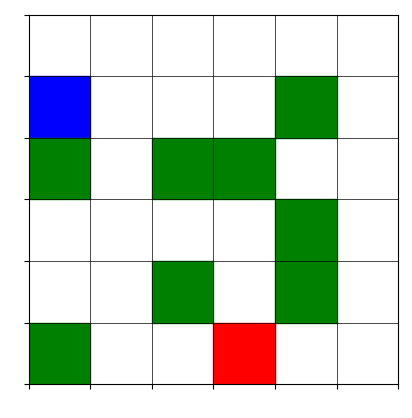

In [ ]:
env = GridWorldEnv(map_size=MAP_SIZE, num_of_trees=NUM_OF_TREES)
env.reset(seed=SEED)
env.render()

Plot Functions

In [ ]:
def plot_rewards(rewards_seq, runs_no):
    plt.figure()
    mean_reward = np.mean(rewards_seq, axis=0)
    std_reward = np.std(rewards_seq, axis=0)

    upper_bound = mean_reward + 1.96 * std_reward / np.sqrt(runs_no)
    lower_bound = mean_reward - 1.96 * std_reward / np.sqrt(runs_no)

    fig, ax = plt.subplots()
    ax.plot(mean_reward, linewidth=0.7)
    ax.fill_between(np.arange(len(mean_reward)), lower_bound ,upper_bound , alpha=0.5, label="Confidence Interval")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title("Mean Reward")
    plt.show()

def plot_heatmap(state_values):
    plt.figure()
    data = np.round(state_values, decimals=2)
    ax = sns.heatmap(data, annot=True, fmt='.2f', cmap='flare', cbar=True)
    ax.set_title('State Values')
    plt.show()


def plot_arrows(state_values, env):
    data = state_values
    arrows = [[None for _ in range(6)] for _ in range(6)]

    for state in itertools.product(range(env.map_size), range(env.map_size)):
        max_nsv = float('-inf')
        max_adj_state = None
        for adj in env._get_adjacents(state):
            nsv = data[adj[X], adj[Y]]
            if nsv > max_nsv:
                max_nsv = nsv
                max_adj_state = adj

        direction = tuple(np.array(max_adj_state) - np.array(state))
        if direction == (1,0):
            arrow = '↓'
        elif direction == (-1,0):
            arrow = '↑'
        elif direction == (0,1):
            arrow = '→'
        elif direction == (0,-1):
            arrow = '←'

        arrows[state[X]][state[Y]] = arrow

    env.render(arrows)

Q-Learning

In [ ]:
class QLearning():
    def __init__(self, env, discount, lr_val, lr_st, episodes):
        self.env = env
        self.discount = discount
        self.lr_val = lr_val
        self.lr_st = lr_st
        self.episodes = episodes

        self.reset()

    def _policy(self, state):
        optimal_action = np.argmax(self.q_values[state[X]][state[Y]][:])
        p = np.ones(4) * self.epsilon / 4
        p[optimal_action] = 1 - 3/4 * self.epsilon
        return np.random.choice(ACTION_SPACE, p=p)

    def update(self):
        s = self.env._agent_location
        terminated = False
        truncated = False

        rewards = []
        while not (terminated or truncated):
            action = self._policy(s)
            observation, reward, terminated, truncated, info = self.env.step(action)
            rewards.append(reward)
            ns = observation["agent"]
            self.q_values[s[X]][s[Y]][action] += self.lr_val * (reward + self.discount * max(self.q_values[ns[X]][ns[Y]][:]) - self.q_values[s[X]][s[Y]][action])
            s = ns

        return sum(rewards)

    def fit(self):
        for i in range(self.episodes):
            self.epsilon = 100 / (i+100)
            if self.lr_st == "variable":
                self.lr_val = 100 / (i+100)
            self.env.reset(seed=SEED)
            self.update()
            self.rewards.append(self.update())

        return self.rewards

    def get_q_values(self):
        return self.q_values

    def get_state_values(self):
        self.state_values = np.zeros((self.env.map_size, self.env.map_size))
        for state in itertools.product(range(self.env.map_size), range(self.env.map_size)):
            self.state_values[state[X]][state[Y]] = max(self.q_values[state[X]][state[Y]][:])

        self.state_values[self.env._target_location[X]][self.env._target_location[Y]] = 200
        return self.state_values

    def reset(self):
        self.env.reset(seed=SEED)
        self.q_values = np.zeros((self.env.map_size, self.env.map_size, 4))
        self.rewards = []

Learning Rate = 0.1

1th run lasted 5.28 seconds
2th run lasted 12.46 seconds
3th run lasted 7.7 seconds
4th run lasted 8.15 seconds
5th run lasted 3.07 seconds
6th run lasted 3.09 seconds
7th run lasted 2.79 seconds
8th run lasted 3.99 seconds
9th run lasted 2.85 seconds
10th run lasted 2.76 seconds


<Figure size 640x480 with 0 Axes>

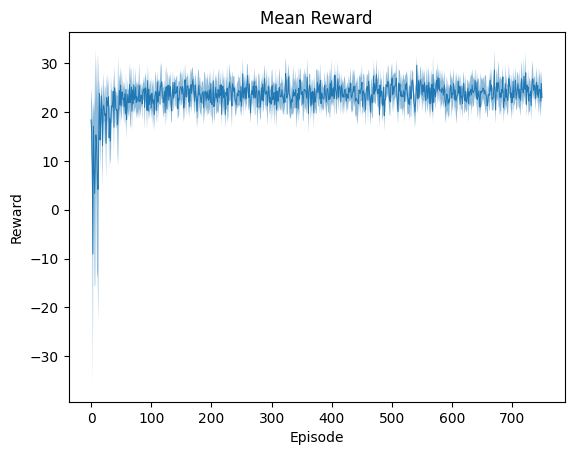

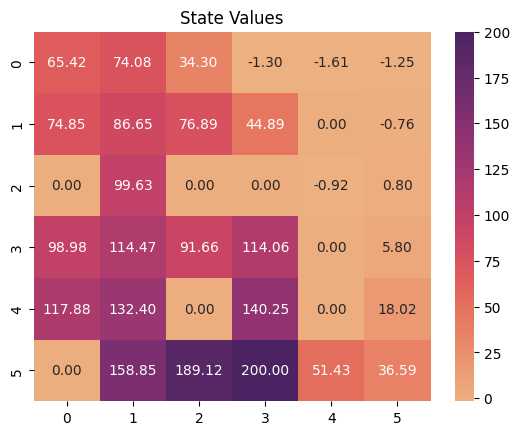

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


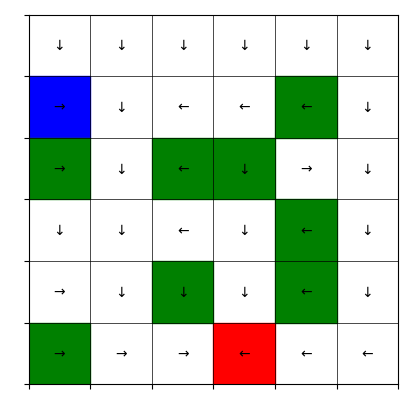

In [ ]:
runs_no = 10
rewards_seq = []
for i in range(runs_no):
    start_time = time.time()
    QL = QLearning(env, discount=0.9, lr_val=0.1, lr_st="fixed", episodes=750)
    rewards_seq.append(QL.fit())
    print(f"{i+1}th run lasted {round((time.time() - start_time),2)} seconds")

plot_rewards(np.array(rewards_seq), runs_no)
plot_heatmap(QL.get_state_values())
plot_arrows(QL.get_state_values(), env)

Variable Learning Rate

1th run lasted 3.11 seconds
2th run lasted 3.9 seconds
3th run lasted 2.81 seconds
4th run lasted 3.08 seconds
5th run lasted 3.22 seconds
6th run lasted 4.04 seconds
7th run lasted 3.09 seconds
8th run lasted 2.85 seconds
9th run lasted 2.75 seconds
10th run lasted 3.61 seconds


<Figure size 640x480 with 0 Axes>

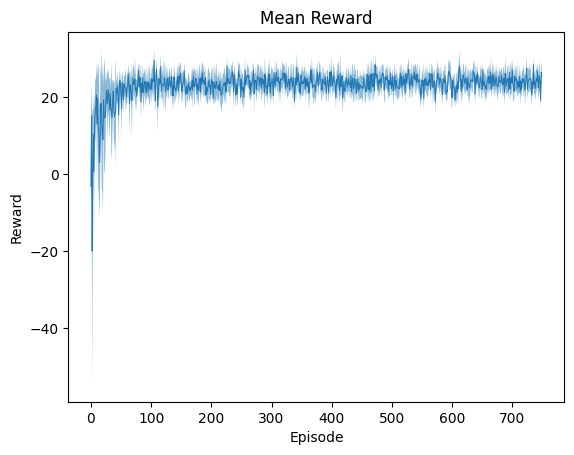

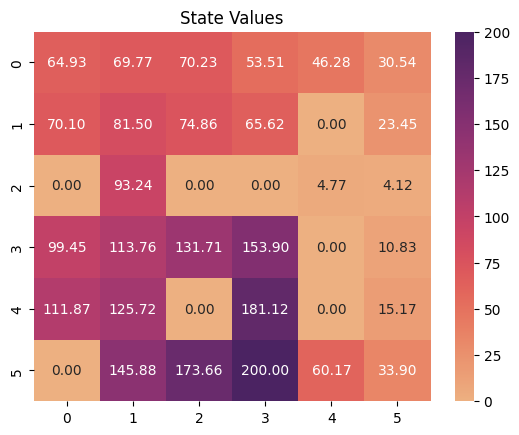

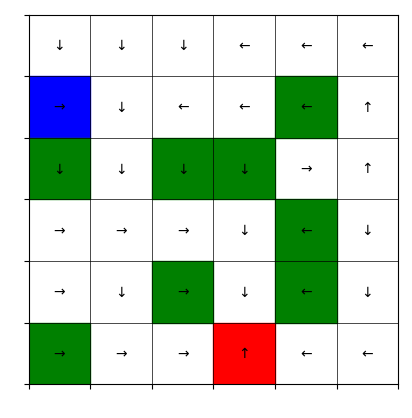

In [ ]:
runs_no = 10
rewards_seq = []
for i in range(runs_no):
    start_time = time.time()
    QL = QLearning(env, discount=0.9, lr_val=0.1, lr_st="variable", episodes=750)
    rewards_seq.append(QL.fit())
    print(f"{i+1}th run lasted {round((time.time() - start_time),2)} seconds")

plot_rewards(np.array(rewards_seq), runs_no)
plot_heatmap(QL.get_state_values())
plot_arrows(QL.get_state_values(), env)

SARSA

In [ ]:
class SARSA():
    def __init__(self, env, discount, lr, episodes):
        self.env = env
        self.discount = discount
        self.lr = lr
        self.episodes = episodes

        self.reset()

    def _policy(self, state):
        optimal_action = np.argmax(self.q_values[state[X]][state[Y]][:])
        p = np.ones(4) * self.epsilon / 4
        p[optimal_action] = 1 - 3/4 * self.epsilon
        return np.random.choice(ACTION_SPACE, p=p)

    def update(self):
        s = self.env._agent_location
        a = self._policy(s)
        terminated = False
        truncated = False

        rewards = []
        while not (terminated or truncated):
            observation, reward, terminated, truncated, info = self.env.step(a)
            rewards.append(reward)
            ns = observation["agent"]
            na = self._policy(ns)
            self.q_values[s[X]][s[Y]][a] += self.lr * (reward + self.discount * self.q_values[ns[X]][ns[Y]][na] - self.q_values[s[X]][s[Y]][a])
            s = ns
            a = na

        return sum(rewards)

    def fit(self):
        for i in range(self.episodes):
            self.epsilon = 100 / (i+100)
            self.env.reset(seed=SEED)
            self.rewards.append(self.update())

        return self.rewards

    def get_q_values(self):
        return self.q_values

    def get_state_values(self):
        self.state_values = np.zeros((self.env.map_size, self.env.map_size))
        for state in itertools.product(range(self.env.map_size), range(self.env.map_size)):
            self.state_values[state[X]][state[Y]] = max(self.q_values[state[X]][state[Y]][:])

        self.state_values[self.env._target_location[X]][self.env._target_location[Y]] = 200
        return self.state_values

    def reset(self):
        self.env.reset(seed=SEED)
        self.q_values = np.zeros((self.env.map_size, self.env.map_size, 4))
        self.rewards = []

1th run lasted 2.79 seconds
2th run lasted 2.77 seconds
3th run lasted 2.47 seconds
4th run lasted 3.36 seconds
5th run lasted 3.21 seconds
6th run lasted 2.65 seconds
7th run lasted 2.63 seconds
8th run lasted 2.6 seconds
9th run lasted 3.8 seconds
10th run lasted 2.8 seconds


<Figure size 640x480 with 0 Axes>

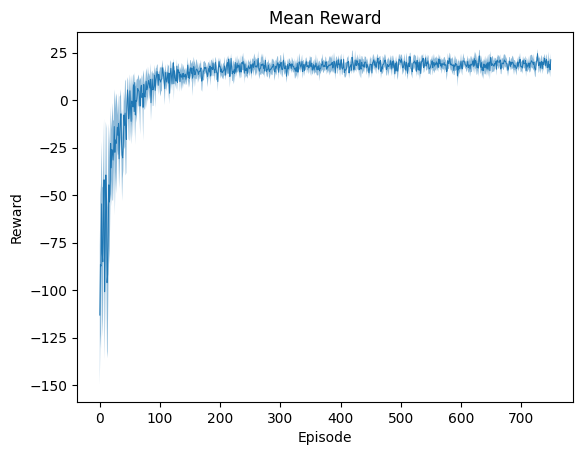

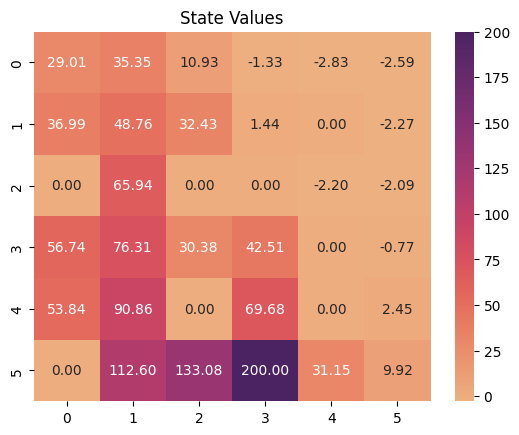

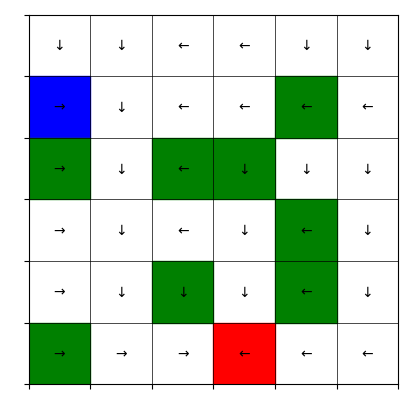

In [ ]:
runs_no = 10
rewards_seq = []
for i in range(runs_no):
    start_time = time.time()
    S = SARSA(env, discount=0.9, lr=0.1, episodes=750)
    rewards_seq.append(S.fit())
    print(f"{i+1}th run lasted {round((time.time() - start_time),2)} seconds")

plot_rewards(np.array(rewards_seq), runs_no)
plot_heatmap(S.get_state_values())
plot_arrows(S.get_state_values(), env)

Tree Backup n-Step

on-Policy MC

In [ ]:
class MonteCarlo():
    def __init__(self, env, discount, epsilon_val, epsilon_st, episodes):
        self.env = env
        self.discount = discount
        self.epsilon_val = epsilon_val
        self.epsilon_st = epsilon_st
        self.episodes = episodes

        self.reset()

    def _policy(self, state):
        optimal_action = np.argmax(self.q_values[state[X]][state[Y]][:])
        p = np.ones(4) * self.epsilon_val / 4
        p[optimal_action] = 1 - 3/4 * self.epsilon_val
        return np.random.choice(ACTION_SPACE, p=p)

    def _generate_episode(self):
        s = self.env._agent_location
        terminated = False
        truncated = False

        states = []
        actions = []
        rewards = [0]
        while not (terminated or truncated):
            action = self._policy(s)
            observation, reward, terminated, truncated, info = self.env.step(action)
            states.append(s)
            actions.append(action)
            rewards.append(reward)
            s = observation["agent"]

        return states, actions, rewards

    def update(self):
        S, A, R = self._generate_episode()
        for t in range(len(S)):
            if self.has_visited[S[t][X]][S[t][Y]][A[t]]:
                continue
            else:
                self.has_visited[S[t][X]][S[t][Y]][A[t]] = 1

                G = 0
                for i in range(len(A), t-1, -1):
                    G = self.discount * G + R[i]

                self.returns[S[t][X]][S[t][Y]][A[t]].append(G)

            returns_sa = self.returns[S[t][X]][S[t][Y]][A[t]]
            self.q_values[S[t][X]][S[t][Y]][A[t]] = sum(returns_sa) / len(returns_sa)

        return sum(R)

    def fit(self):
        for i in range(self.episodes):
            if self.epsilon_st == "variable":
                self.epsilon_val = 100 / (i+100)
            self.env.reset(seed=SEED)
            self.has_visited = np.zeros((self.env.map_size, self.env.map_size, 4))
            self.rewards.append(self.update())

        return self.rewards

    def get_q_values(self):
        return self.q_values

    def get_state_values(self):
        self.state_values = np.zeros((self.env.map_size, self.env.map_size))
        for state in itertools.product(range(self.env.map_size), range(self.env.map_size)):
            self.state_values[state[X]][state[Y]] = max(self.q_values[state[X]][state[Y]][:])

        self.state_values[self.env._target_location[X]][self.env._target_location[Y]] = 30
        return self.state_values

    def reset(self):
        self.env.reset(seed=SEED)
        self.q_values = np.zeros((self.env.map_size, self.env.map_size, 4))
        self.returns = [[[[] for _ in range(4)] for _ in range(self.env.map_size)] for _ in range(self.env.map_size)]
        self.rewards = []

Variable epsilon

1th run lasted 2.48 seconds
2th run lasted 2.55 seconds
3th run lasted 4.08 seconds
4th run lasted 3.3 seconds
5th run lasted 2.44 seconds
6th run lasted 2.9 seconds
7th run lasted 2.95 seconds
8th run lasted 3.59 seconds
9th run lasted 2.67 seconds
10th run lasted 2.72 seconds


<Figure size 640x480 with 0 Axes>

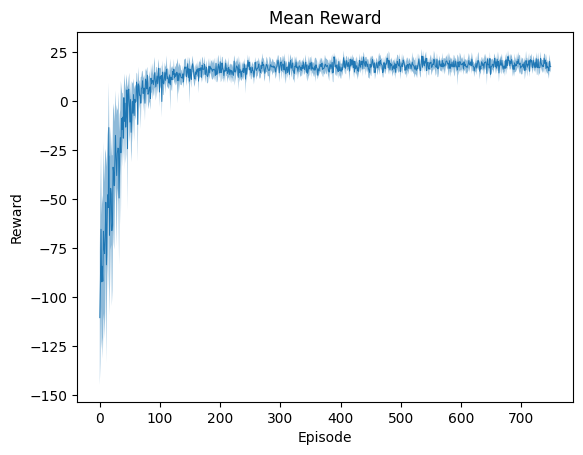

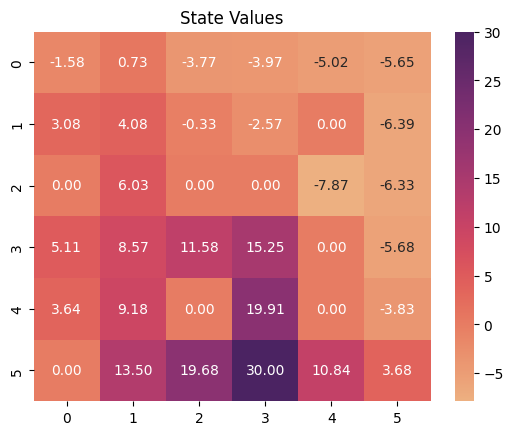

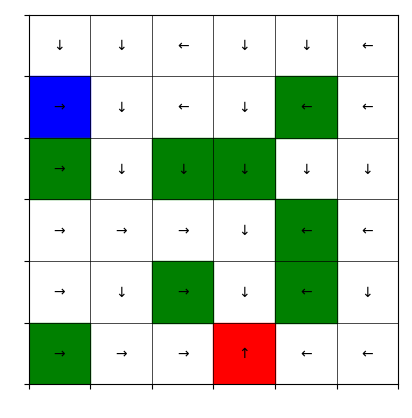

In [ ]:
runs_no = 10
rewards_seq = []
for i in range(runs_no):
    start_time = time.time()
    MC = MonteCarlo(env, discount=0.9, epsilon_val=0.1, epsilon_st="variable", episodes=750)
    rewards_seq.append(MC.fit())
    print(f"{i+1}th run lasted {round((time.time() - start_time),2)} seconds")

plot_rewards(np.array(rewards_seq), runs_no)
plot_heatmap(MC.get_state_values())
plot_arrows(MC.get_state_values(), env)

epsilon = 0.1

1th run lasted 2.28 seconds
2th run lasted 3.1 seconds
3th run lasted 3.04 seconds
4th run lasted 2.63 seconds
5th run lasted 13.71 seconds
6th run lasted 5.8 seconds
7th run lasted 2.7 seconds
8th run lasted 3.49 seconds
9th run lasted 3.99 seconds
10th run lasted 2.16 seconds


<Figure size 640x480 with 0 Axes>

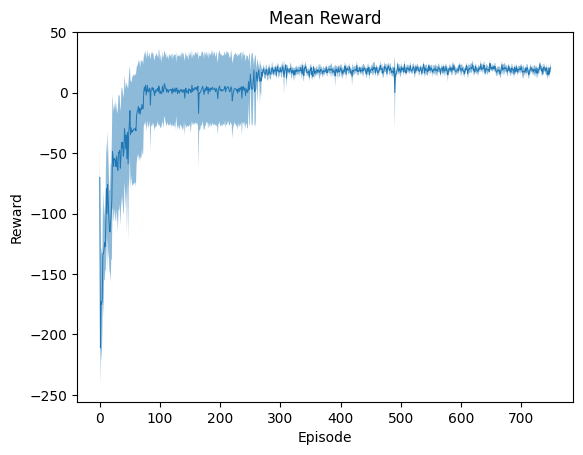

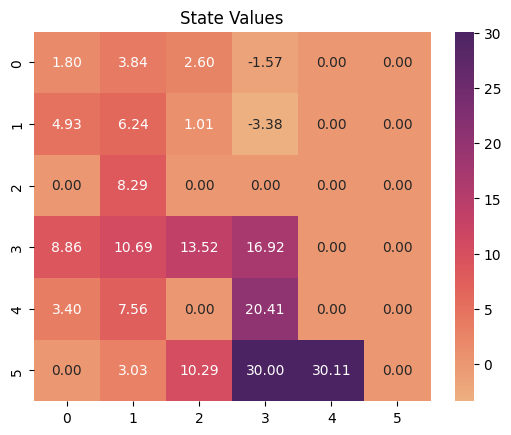

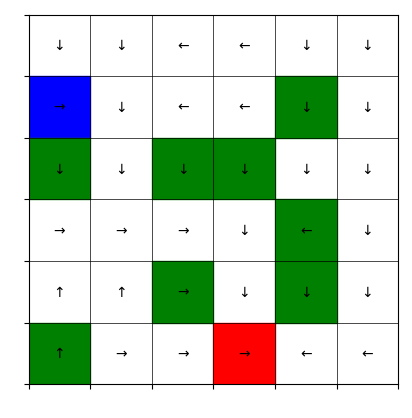

In [ ]:
runs_no = 10
rewards_seq = []
for i in range(runs_no):
    start_time = time.time()
    MC = MonteCarlo(env, discount=0.9, epsilon_val=0.1, epsilon_st="fixed", episodes=750)
    rewards_seq.append(MC.fit())
    print(f"{i+1}th run lasted {round((time.time() - start_time),2)} seconds")

plot_rewards(np.array(rewards_seq), runs_no)
plot_heatmap(MC.get_state_values())
plot_arrows(MC.get_state_values(), env)

Policy Iteration

In [ ]:
class PolicyIteration():
    def __init__(self, env, discount, theta):
        self.env = env
        self.discount = discount
        self.theta = theta

        self.reset()

    def policy_evaluation(self):
        self.delta = np.inf

        while(self.delta > self.theta):
            self.delta = 0

            for state in itertools.product(range(self.env.map_size), range(self.env.map_size)):

                punishment = 0
                if any(np.array_equal(state, tree) for tree in self.env._trees_location):
                    punishment = -100

                for action in ACTION_SPACE:
                    next_states, states_probabilities, has_collided, has_arrived = self.env.find_next_states(
                        action = action,
                        current_state = (state[X], state[Y]),
                    )

                    # Calc rewards
                    next_state_rewards = np.array([
                        -0.5 + int(has_collided[ns]) * -10 + int(has_arrived[ns]) * 25
                        for ns in range(len(next_states))
                    ], dtype=float)

                    # Belman Equation
                    next_state_values = self.state_values[np.array(next_states)[:, X], np.array(next_states)[:, Y]]
                    self.q_values[state[X], state[Y], action] = np.sum(
                        states_probabilities * (next_state_rewards + self.discount * next_state_values),
                    )

                v = self.state_values[state[X], state[Y]]

                optimal_action = self.optimal_policy[state[X]][state[Y]]
                self.state_values[state[X], state[Y]] = self.q_values[state[X], state[Y], optimal_action] + punishment

                self.delta = np.max([self.delta, abs(v - self.state_values[state[X], state[Y]])])

    def policy_improvement(self):
        self.policy_stable = True
        old_policy = self.optimal_policy.copy()
        for state in itertools.product(range(self.env.map_size), range(self.env.map_size)):
            self.optimal_policy[state[X], state[Y]] = self.get_optimal_policy([state[X], state[Y]])
        if not (old_policy == self.optimal_policy).all():
            self.policy_stable = False

    def fit(self):
        while(not self.policy_stable):
            self.policy_evaluation()
            self.policy_improvement()

    def get_optimal_policy(self, state):
        return np.argmax(self.q_values[state[X], state[Y], :])

    def get_state_values(self):
        return self.state_values

    def get_q_values(self):
        return self.q_values

    def reset(self):
        self.env.reset(seed=SEED)
        self.delta = 0
        self.state_values = np.zeros((self.env.map_size, self.env.map_size))
        self.q_values = np.zeros((self.env.map_size, self.env.map_size, 4))
        self.optimal_policy = np.random.randint(4, size=(self.env.map_size, self.env.map_size))
        self.policy_stable = False

run lasted 22.67 seconds


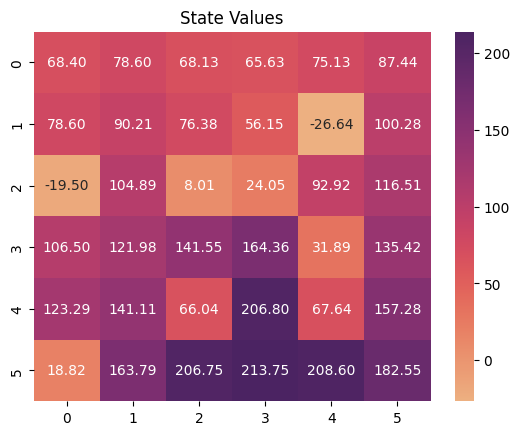

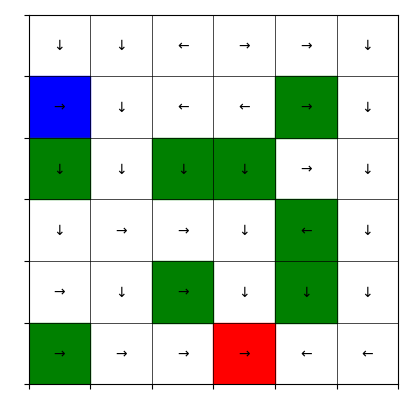

mean reward in 100 runs: 20.564715412765512


In [ ]:
start_time = time.time()
PI = PolicyIteration(env, discount=0.9, theta=1e-6)
PI.fit()
print(f"run lasted {round((time.time() - start_time),2)} seconds")

plot_heatmap(PI.get_state_values())
plot_arrows(PI.get_state_values(), env)

rewards = []
runs_no = 100
for i in range(runs_no):
    env.reset(seed=SEED)
    score = 0
    while True:
        action = PI.get_optimal_policy(env._agent_location)
        observation, reward, terminated, truncated, info = env.step(action)
        score += reward
        if terminated or truncated:
            env.reset(seed=SEED)
            break

    rewards.append(score)

print(f'mean reward in 100 runs: {sum(rewards) / len(rewards)}')